# Pip Installs

In [2]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile
!pip install alive-progress
!pip install --upgrade pytube

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [3]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import yt_dlp

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# File Creation

### Creating File Paths

In [4]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Training_Wav_Files"
proccesed_data_dir = os.path.abspath('') + "/Processed_Training_Wav_Files"

# YouTube Audio Download

In [ ]:
def download_audio(url, starttime, endtime, output):
    # Convert start and end times to seconds
    hours, minutes, seconds = map(int, starttime.split(':'))
    start_time = hours * 3600 + minutes * 60 + seconds
    hours, minutes, seconds = map(int, endtime.split(':'))
    end_time = hours * 3600 + minutes * 60 + seconds

    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio format
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio after download
            'preferredcodec': 'wav',  # Convert to wav format
        }],
        'noplaylist': True,  # Avoid downloading playlists, download a single video
        'quiet': False,  # Show output in the terminal
        'outtmpl': 'temp_audio.%(ext)s',  # Temporary output for the full audio
    }

    #Use yt-dlp to download the audio
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

    #Load the downloaded audio using pydub (assume the file was saved as temp_audio.wav)
    audio_file = audio.from_wav('temp_audio.wav')

    #Extract the desired clip (convert time to milliseconds)
    start_time_ms = start_time * 1000  # Convert start time from seconds to milliseconds
    end_time_ms = end_time * 1000      # Convert end time from seconds to milliseconds
    clip = audio_file[start_time_ms:end_time_ms]

    #Export the extracted clip as a new WAV file
    clip.export(output, format="wav")
    print(f"Audio clip saved to {output}")

    #Clean up the temporary file
    os.remove('temp_audio.wav')

starttime = '0:37:58' 
endtime = '0:39:33'
name = 'peteStauber40533Clip1'
download_audio(url='https://www.youtube.com/watch?v=EELSevWNbIk',
               starttime=starttime,
               endtime=endtime,
               output=f'{unprocessed_data_dir}/{name}.wav')

[youtube] Extracting URL: https://www.youtube.com/watch?v=EELSevWNbIk
[youtube] EELSevWNbIk: Downloading webpage
[youtube] EELSevWNbIk: Downloading ios player API JSON
[youtube] EELSevWNbIk: Downloading mweb player API JSON
[youtube] EELSevWNbIk: Downloading m3u8 information
[info] EELSevWNbIk: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of  255.41MiB in 00:00:10 at 23.97MiB/s    
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio clip saved to /Users/ryanbirmingham/Downloads/Sunwater Projects/congressional_voice_classification/Unprocessed_Training_Wav_Files/peteStauber40533Clip1.wav


Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [24]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [25]:
for file in os.listdir(unprocessed_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

This is a test

In [26]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


### Separates the files into 1 second intervals

In [27]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{proccesed_data_dir}/{congress_name}")
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [28]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Training_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [29]:
num_data = 0

for foldr in os.listdir(proccesed_data_dir):
    if foldr != ".DS_Store":
        num_data += len(os.listdir(f"{proccesed_data_dir}/{foldr}"))

In [32]:
def feature_extract (data_dir):
    features = []
    labels = []
    with alive_bar(num_data,force_tty=True, title='Collecting Features', bar = 'scuba') as bar: 
        for foldr in os.listdir(data_dir):
            if foldr != ".DS_Store":
                for file in os.listdir(f"{data_dir}/{foldr}"):
                    arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                    mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                    mfccs = StandardScaler().fit_transform(mfccs)
                    features.append(mfccs.T)
                    labels.append(foldr)
                    bar()
                
                
    return np.array(features), np.array(labels)           
features, labels = feature_extract(proccesed_data_dir)

AttributeError: module 'soundfile' has no attribute 'SoundFileRuntimeError'

### Feature Visualization

In [ ]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: jamesJordan, Features Shape: (32, 13)
[-3.360361   -0.1903183   0.77904576  0.15367031  0.22454423  0.7346955
  0.19315235  0.37246782  0.30784097  0.07275002  0.29632047  0.19204979
  0.22414224]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.004173    1.3296394  -0.24910702  1.3453428   0.13564226 -0.1008335
  0.27885127  0.10520647  0.15796548 -0.3386022   0.19895187  0.18986304
 -0.04874685]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.0829401e+00  1.5331542e+00  1.5818969e-04  9.0373278e-01
  2.7616814e-01 -1.6860381e-01  1.2954178e-01  5.0936118e-02
  3.0296618e-01 -2.4682966e-01  1.3251595e-01  1.8341005e-01
 -1.4209974e-02]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.2771137   0.8414707   0.16856258  1.0565054   0.38853514  0.03541012
  0.28715527  0.11213993  0.25858703 -0.12735942 -0.05219261  0.27088258
  0.03741675]
-------------------

### Training and splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [ ]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)

In [ ]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(6195, 32, 13)
(6195,)


### Reshape for SVM since it takes 2D arrays

In [ ]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(6195, 416)
(6195,)
['jamesJordan' 'jamesJordan' 'jamesJordan' ... 'thomasKean'
 'sheldonWhitehouse' 'stephenCohen']


### Trying the SVM approach

In [ ]:
clm = SVC(kernel="linear", probability=True)

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.6520335700451905


#### Shows the probability for each label for each data set

In [ ]:
prob = clm.predict_proba(X_test_SVM)
for i, arr in enumerate(prob):
    prob[i] = np.round(arr * 100,3)

#### Prints all of the probabilities for each test data point

In [ ]:
#np.set_printoptions(suppress=True)
#for i in prob:
#    print(i)

#### Prints the True Value, the predicted Value, and the certainty for each test data point

In [ ]:
max = 0
for i, val in enumerate(prob):
    max = np.max(val)
    print(f"The True value is {y_test[i]}\n"
          f"The Predicted value is {y_predict[i]} and is {max} certain\n")
    

The True value is maríaSalazar
The Predicted value is addisonWilson and is 15.005 certain

The True value is thomasKean
The Predicted value is thomasKean and is 88.011 certain

The True value is addisonWilson
The Predicted value is addisonWilson and is 96.721 certain

The True value is christopherSmith
The Predicted value is christopherSmith and is 83.344 certain

The True value is jerroldNadler
The Predicted value is williamKeating and is 91.786 certain

The True value is christopherSmith
The Predicted value is christopherSmith and is 89.099 certain

The True value is jerroldNadler
The Predicted value is jerroldNadler and is 24.271 certain

The True value is thomasKean
The Predicted value is thomasKean and is 93.544 certain

The True value is jerroldNadler
The Predicted value is williamKeating and is 23.121 certain

The True value is maríaSalazar
The Predicted value is christopherSmith and is 49.122 certain

The True value is samuelGraves
The Predicted value is samuelGraves and is 6

In [ ]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

jamesJordan 
	accuracy = 0.71875
	predict/real = 46/64
thomasKean 
	accuracy = 0.6986301369863014
	predict/real = 102/146
brianMast 
	accuracy = 0.6619718309859155
	predict/real = 94/142
kevinKiley 
	accuracy = 0.7878787878787878
	predict/real = 26/33
christopherSmith 
	accuracy = 0.75
	predict/real = 81/108
victoriaSpartz 
	accuracy = 0.4
	predict/real = 12/30
richardLarsen 
	accuracy = 0.7741935483870968
	predict/real = 48/62
samuelGraves 
	accuracy = 0.5698924731182796
	predict/real = 53/93
maríaSalazar 
	accuracy = 0.2978723404255319
	predict/real = 14/47
christineSmith 
	accuracy = 0.6
	predict/real = 6/10
michaelQuigley 
	accuracy = 0.5517241379310345
	predict/real = 16/29
williamKeating 
	accuracy = 0.6492537313432836
	predict/real = 87/134
addisonWilson 
	accuracy = 0.8537549407114624
	predict/real = 216/253
jerroldNadler 
	accuracy = 0.6619718309859155
	predict/real = 47/71
michaelLawler 
	accuracy = 0.5921052631578947
	predict/real = 45/76
stephenCohen 
	accuracy = 0.5116279

Test Evaluation Accuracy: 0.6520335700451905


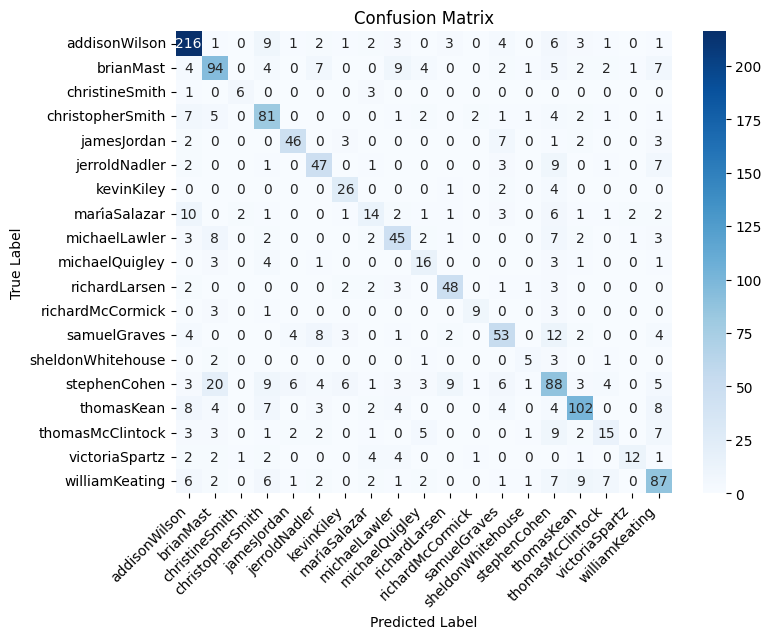

In [ ]:
# Decode the labels back to original format
#y_test_decoded = label_encoder.inverse_transform(y_test)
#y_pred_decoded = label_encoder.inverse_transform(y_predict)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try RNN LSTM approach

### Training and testing

In [ ]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.2049 - loss: 2.5442
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4964 - loss: 1.6276
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6024 - loss: 1.2526
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6652 - loss: 1.0191
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6937 - loss: 0.9398
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7163 - loss: 0.8648
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7278 - loss: 0.8096
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7539 - loss: 0.7542
Epoch 9/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7795 - loss: 0.6534
Epoch 10/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.7905 - loss: 0.6450
Epoch 11/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8116 - loss: 0.5804
Epoch 12/20
194/194 ━━━━━━━━━━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test Evaluation Accuracy: 0.8147191736604261


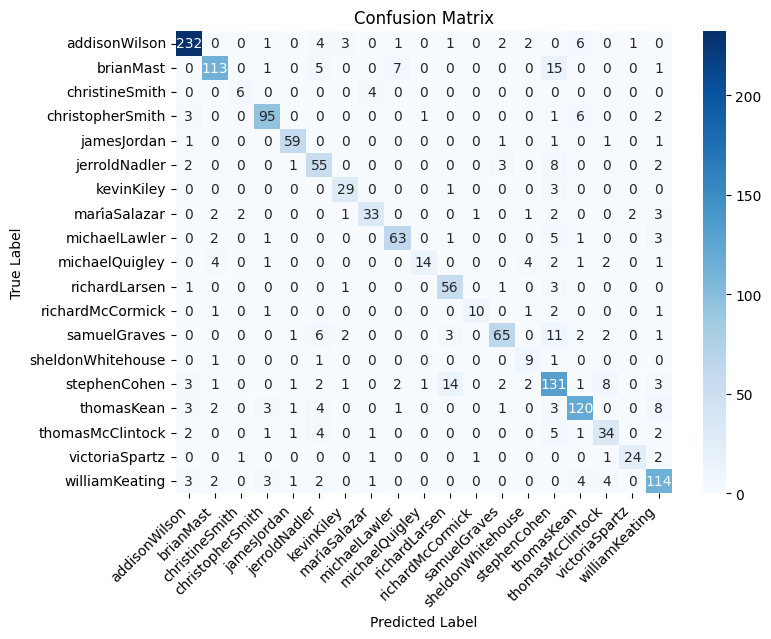

In [ ]:
y_pred_probabilities = model.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try GRU RNN approach

In [ ]:
num_speakers = len(next(os.walk(proccesed_data_dir))[1])

np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,875 (226.07 KB)

 Trainable params: 57,619 (225.07 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.2157 - loss: 2.8902 - val_accuracy: 0.2983 - val_loss: 2.4383
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5417 - loss: 1.4965 - val_accuracy: 0.3525 - val_loss: 2.2110
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5944 - loss: 1.3163 - val_accuracy: 0.3434 - val_loss: 3.3065
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6301 - loss: 1.2050 - val_accuracy: 0.3951 - val_loss: 2.4399
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6481 - loss: 1.1475 - val_accuracy: 0.2498 - val_loss: 3.7901
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6583 - loss: 1.0786 - val_accuracy: 0.4293 - val_loss: 2.1729
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6767 - loss: 1.0283 - val_accuracy: 0.4435 - val_loss: 2.1261
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6919 - loss: 0.9865 - val_acc

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1549
Test Evaluation Accuracy: 0.788896061975468


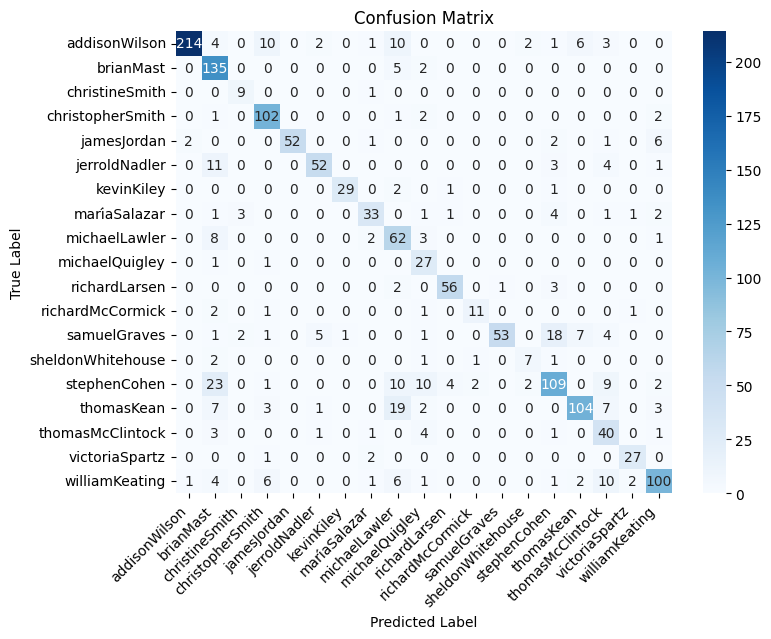

In [ ]:
y_pred_probabilities = gru.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()